# Pneumonia Pre-Processing and Modeling

## Import Revelant Packages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.ndimage as ndi
from sklearn.utils import shuffle
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
import tensorflow as tf
from tensorflow import keras
from keras import models
from keras import layers
from keras import backend as K

## Import Data

In [2]:
df_train = pd.read_pickle('Clean_Data/training_data.csv')
df_test = pd.read_pickle('Clean_Data/testing_data.csv')
df_val = pd.read_pickle('Clean_Data/validation_data.csv')

## Explore Data

In [3]:
print(df_train.head(1))
print(df_test.head(1))
print(df_val.head(1))

                                               Image   Label
0  [[29, 27, 30, 28, 27, 26, 28, 29, 30, 29, 28, ...  Normal
                                               Image   Label
0  [[25, 24, 21, 19, 19, 21, 20, 21, 20, 20, 20, ...  Normal
                                               Image   Label
0  [[6, 23, 32, 30, 40, 37, 44, 43, 40, 38, 39, 4...  Normal


In [4]:
print(df_train.shape)
print(df_test.shape)
print(df_val.shape)

(5216, 2)
(624, 2)
(16, 2)


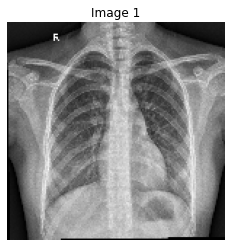

In [5]:
_ = plt.imshow(df_train['Image'][0], cmap='gray')
_ = plt.axis('off')
_ = plt.title('Image 1')

In [6]:
df_train['Image'][0].shape

(150, 150)

## Preprocess Data

### Shuffle Images

In [7]:
df_train = shuffle(df_train).reset_index(drop=True)
df_test = shuffle(df_test).reset_index(drop=True)
df_val = shuffle(df_val).reset_index(drop=True)

### Equalize Images

In [8]:
def equalize(image_list):
    im_equalized = []
    for im in image_list.index:
        hist = ndi.histogram(image_list[im], min=0, max=255, bins=256)
        cdf = hist.cumsum() / hist.sum()
        im_equalized.append(cdf[image_list[im]] * 255)
    return im_equalized

In [9]:
df_train['Equalize_Image'] = equalize(df_train['Image'])
df_test['Equalize_Image'] = equalize(df_test['Image'])
df_val['Equalize_Image'] = equalize(df_val['Image'])

### Split Data, Reshape & Correct Dtypes

In [10]:
X_train = df_train['Image']
# Reshape image array so 4D (Number of Images, Image Width, Image Height, Color Channels)
X_train = np.concatenate(X_train).reshape(-1, 150, 150, 1)
# Replace string labels with numeric (Pneumonia = 1, Normal = 0)
y_train = np.array(df_train['Label'].replace(['Pneumonia', 'Normal'],[1,0]))

X_test = df_test['Image']
# Reshape image array so 4D (Number of Images, Image Width, Image Height, Color Channels)
X_test = np.concatenate(X_test).reshape(-1, 150, 150, 1)
# Replace string labels with numeric (Pneumonia = 1, Normal = 0)
y_test = np.array(df_test['Label'].replace(['Pneumonia', 'Normal'],[1,0]))

X_val = df_val['Image']
# Reshape image array so 4D (Number of Images, Image Width, Image Height, Color Channels)
X_val = np.concatenate(X_val).reshape(-1, 150, 150, 1)
# Replace string labels with numeric (Pneumonia = 1, Normal = 0)
y_val = np.array(df_val['Label'].replace(['Pneumonia', 'Normal'],[1,0]))

In [11]:
print('Training data shape : ', X_train.shape, y_train.shape)
print('Testing data shape : ', X_test.shape, y_test.shape)
print('Validation data shape : ', X_val.shape, y_val.shape)

Training data shape :  (5216, 150, 150, 1) (5216,)
Testing data shape :  (624, 150, 150, 1) (624,)
Validation data shape :  (16, 150, 150, 1) (16,)


### Correct For Class Imbalance

In [12]:
# Count number of each label
label_counts = np.unique(y_train, return_counts=True)
# Define normal, pneumonia and total counts
num_normal = label_counts[1][0]
num_pneumonia = label_counts[1][1]
num_total = len(y_train)

# Determine weights of normal and pneumonia classes
weight_normal = round((1 / num_normal)*(num_total)/2.0, 2) 
weight_pneumonia = round((1 / num_pneumonia)*(num_total)/2.0, 2)
print("Normal Weight:", weight_normal)
print("Pneumonia Weight:", weight_pneumonia)

# Build dictionary of class weights to read into model
class_weight = {0: weight_normal, 1: weight_pneumonia}

Normal Weight: 1.94
Pneumonia Weight: 0.67


### Data Augmentation

To avoid overfitting data due to small image set.
- Rescale to normalize arrays
- Randomly rotate in range of 15 degrees
- Randomly zoom inputs by range of 20%
- Randomly shift width by range of 10%
- Randomly shift height by range of 10%
- Randomly flip horizontally

In [13]:
# Generate batches of tensor image data with real-time data augmentation
train_datagen = ImageDataGenerator(
        rescale=1.0/255,
        rotation_range = 20, # Randomly rotate inputs by range of 30 degrees
        zoom_range = 0.2, # Randomly zoom inputs by range of 20%
        width_shift_range=0.1, # Randomly shift width by range of 10%
        height_shift_range=0.1, # Randomly shift height by range of 10%
        horizontal_flip = True) # Randomly flip inputs horizontally 
        
test_datagen = ImageDataGenerator(rescale=1.0/255)

training_set = train_datagen.flow(X_train, y_train)

validation_generator = train_datagen.flow(X_val, y_val)

test_set = test_datagen.flow(X_test, y_test)

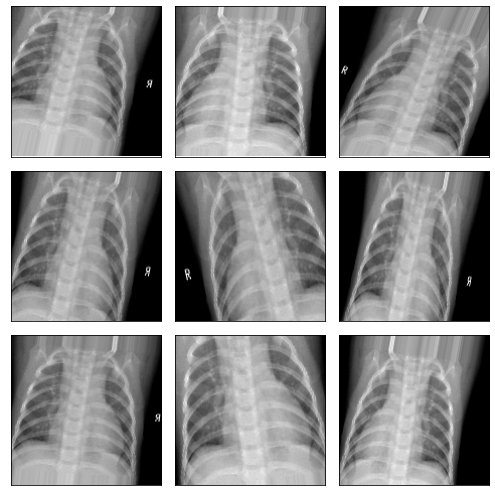

In [14]:
# Visualize 9 augmented samples of image in training set
def plotImages(images_arr):
    fig, axes = plt.subplots(3, 3, figsize=(7,7))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
    plt.tight_layout()
    plt.show()
    
augmented_images = [training_set[0][0][0] for i in range(9)]
plotImages(augmented_images)

## Make Model

In [15]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    
    # Entry block
    x = layers.Conv2D(32, (3,3), padding="same")(inputs)
    x = layers.Activation("relu")(x)
    x = layers.BatchNormalization()(x)
    
    x = layers.MaxPooling2D((2,2), padding="same")(x)
    
    x = layers.SeparableConv2D(32, (3,3), strides=1, padding="same")(x)
    x = layers.Activation("relu")(x)
    x = layers.BatchNormalization()(x)
    
    x = layers.MaxPooling2D((2,2), strides=2, padding="same")(x)
    
    x = layers.Conv2D(64, (3,3), padding="same")(x)
    x = layers.Activation("relu")(x)
    x = layers.BatchNormalization()(x)
    
    x = layers.MaxPooling2D((2,2), padding="same")(x)
    
    x = layers.SeparableConv2D(64, (3,3), strides=1, padding="same")(x)
    x = layers.Activation("relu")(x)
    x = layers.BatchNormalization()(x)
    
    x = layers.MaxPooling2D((2,2), strides=2, padding="same")(x)  
    
    x = layers.Flatten()(x)
    
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.5)(x)

    outputs = layers.Dense(1, activation='sigmoid')(x)
    return keras.Model(inputs, outputs)

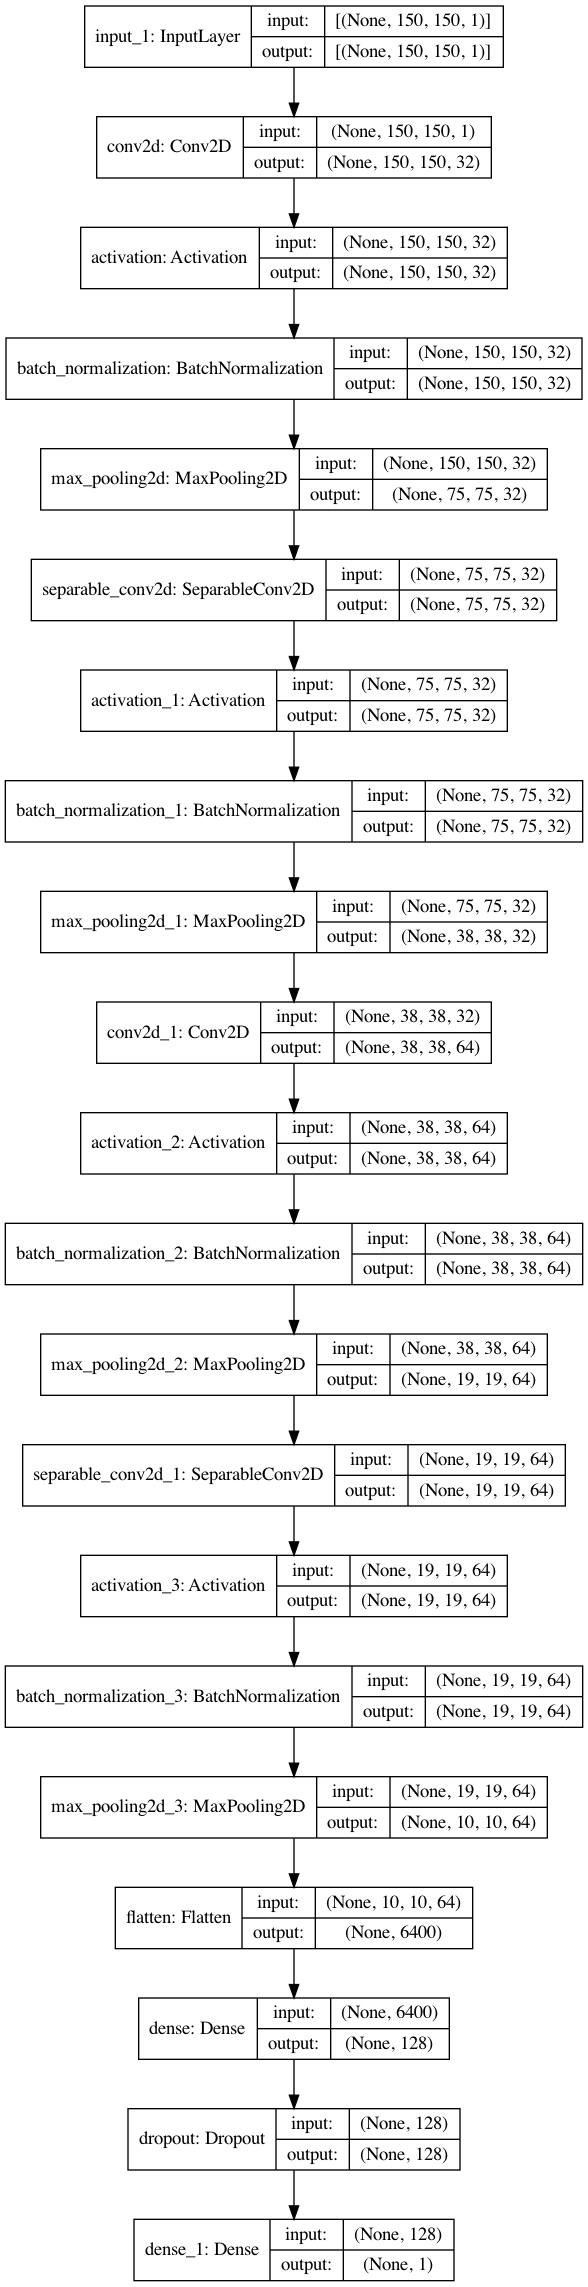

In [16]:
# Create model
model = make_model(input_shape=X_train.shape[1:], num_classes=2)

# Visualize model 
keras.utils.plot_model(model, show_shapes=True)

In [17]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 150, 150, 32)      320       
_________________________________________________________________
activation (Activation)      (None, 150, 150, 32)      0         
_________________________________________________________________
batch_normalization (BatchNo (None, 150, 150, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 32)        0         
_________________________________________________________________
separable_conv2d (SeparableC (None, 75, 75, 32)        1344      
_________________________________________________________________
activation_1 (Activation)    (None, 75, 75, 32)        0     

## Train Model

In [18]:
# Define recall
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

# Define precision
def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

#Define F1 score
def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

# List evaulation metrics
metrics = ['accuracy',
           f1_m,
           recall_m,
           precision_m]

# Reduce learning rate when a metrics stops improving
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=2, 
                                            verbose=1, factor=0.3, min_lr=0.000001)

# Compile model
model.compile(optimizer='adam', loss="binary_crossentropy", metrics=metrics)

In [19]:
history = model.fit(training_set, epochs=6, validation_data=validation_generator, 
                    class_weight=class_weight, callbacks=learning_rate_reduction)

Epoch 1/6
163/163 [==============================] - 86s 517ms/step - loss: 0.6734 - accuracy: 0.8099 - f1_m: 0.8565 - recall_m: 0.8049 - precision_m: 0.9387 - val_loss: 7.0006 - val_accuracy: 0.5000 - val_f1_m: 0.6667 - val_recall_m: 1.0000 - val_precision_m: 0.5000
Epoch 2/6
163/163 [==============================] - 85s 523ms/step - loss: 0.2473 - accuracy: 0.8998 - f1_m: 0.9284 - recall_m: 0.8947 - precision_m: 0.9695 - val_loss: 16.8304 - val_accuracy: 0.5000 - val_f1_m: 0.6667 - val_recall_m: 1.0000 - val_precision_m: 0.5000
Epoch 3/6
163/163 [==============================] - 86s 524ms/step - loss: 0.2381 - accuracy: 0.9025 - f1_m: 0.9316 - recall_m: 0.8969 - precision_m: 0.9730 - val_loss: 17.4313 - val_accuracy: 0.5000 - val_f1_m: 0.6667 - val_recall_m: 1.0000 - val_precision_m: 0.5000

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
Epoch 4/6
163/163 [==============================] - 82s 500ms/step - loss: 0.1926 - accuracy: 0.9316 - f1_m: 0.9

## Evaluate Model Performance

In [20]:
# Evaluate model performance using test data
loss, accuracy, f1_score, precision, recall = model.evaluate(test_set)

20/20 [==============================] - 3s 173ms/step - loss: 0.2796 - accuracy: 0.9119 - f1_m: 0.9312 - recall_m: 0.9676 - precision_m: 0.9012


In [21]:
# Print evaluation results
print("Loss:", loss)
print("Accuracy:", accuracy)
print("F1 Score:", f1_score)
print("Precision:", precision)
print("Recall:", recall)

Loss: 0.2796304523944855
Accuracy: 0.9118589758872986
F1 Score: 0.9312117695808411
Precision: 0.967606246471405
Recall: 0.9011790156364441
